In [1]:
import os
import sys
# SRC_DIR environment variable should be the absolute path to the 'multicopy-STR-genotyping' directory
sys.path.append(os.environ["SRC_DIR"])

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from multicopy_STR_genotyping import file_io

sns.set_context("poster")
%matplotlib inline

In [3]:
df_repeats_constrain, df_constrain = file_io.dfs_from_vcf(filename="../../../data/simulated_reads/variants/ConSTRain_simulated_trisomy_21.vcf", samples=["simulated_trisomy_21"])
df_constrain = df_constrain.rename(columns = {"frequencies": "frequencies_constrain", "genotype": "genotype_constrain"}).dropna().reset_index(drop=True)
df_constrain

,sample,str_id,copy_number,frequencies_constrain,genotype_constrain
0,simulated_trisomy_21,chr21_5011212,3,{3: 55},"[3, 3, 3]"
1,simulated_trisomy_21,chr21_5013077,3,{6: 50},"[6, 6, 6]"
2,simulated_trisomy_21,chr21_5014892,3,{6: 43},"[6, 6, 6]"
3,simulated_trisomy_21,chr21_5016248,3,{6: 40},"[6, 6, 6]"
4,simulated_trisomy_21,chr21_5016789,3,"{9: 12, 10: 32}","[9, 10, 10]"
...,...,...,...,...,...
21477,simulated_trisomy_21,chr21_46688832,3,"{12: 15, 16: 29}","[12, 16, 16]"
21478,simulated_trisomy_21,chr21_46689712,3,{3: 45},"[3, 3, 3]"
21479,simulated_trisomy_21,chr21_46696282,3,{11: 39},"[11, 11, 11]"
21480,simulated_trisomy_21,chr21_46697535,3,{20: 41},"[20, 20, 20]"


In [4]:
df_repeats_hg002 = pd.read_csv("../../../data/HG002/variants/HG002_GRCh38_STR_lengths.csv")
df_repeats_hg002 = df_repeats_hg002[df_repeats_hg002["str_id"].isin(df_constrain["str_id"])].reset_index(drop=True)
df_repeats_hg002

,str_id,region_len_ref,region_len_mat,region_len_pat
0,chr21_5354757,12,12.0,12.0
1,chr21_7205148,18,18.0,18.0
2,chr21_7227685,20,20.0,20.0
3,chr21_8987815,16,16.0,16.0
4,chr21_8987982,10,10.0,10.0
...,...,...,...,...
19439,chr21_46688832,32,24.0,32.0
19440,chr21_46689712,12,12.0,12.0
19441,chr21_46696282,11,11.0,11.0
19442,chr21_46697535,20,20.0,20.0


In [5]:
names = ["chr", "start", "end", "period", "unit"]
df_strs_in_segdup = (pd.read_csv("../../../data/hg38_ver13_0boe_mononucleotides_in_segdup.bed", sep="\t", names=names)
                        .query("chr == 'chr21'")
                        .assign(str_id = lambda x: [f"{i}_{j}" for i, j in zip(x["chr"], x["start"] + 1)]))
df_strs_in_segdup

,chr,start,end,period,unit,str_id
50287,chr21,5011211,5011223,4,AATC,chr21_5011212
50288,chr21,5013076,5013088,2,CA,chr21_5013077
50289,chr21,5014891,5014903,2,CA,chr21_5014892
50290,chr21,5016247,5016265,3,GAG,chr21_5016248
50291,chr21,5016788,5016798,1,G,chr21_5016789
...,...,...,...,...,...,...
53380,chr21,46688831,46688863,2,AC,chr21_46688832
53381,chr21,46689711,46689723,4,ATTT,chr21_46689712
53382,chr21,46696281,46696292,1,T,chr21_46696282
53383,chr21,46697534,46697554,1,A,chr21_46697535


In [65]:
df_comparison = (df_repeats_hg002
     .merge(df_constrain, on="str_id", how="inner")
     .merge(df_repeats_constrain[["str_id", "period", "ref"]], how="inner")
     .assign(region_len_mat = lambda x: x["region_len_mat"].convert_dtypes(int),
             region_len_pat = lambda x: x["region_len_pat"].convert_dtypes(int),
             genotype_constrain = lambda x: [np.array(i) * j for i, j in zip(x["genotype_constrain"], x["period"])],
             genotype_sim = lambda x: [np.array(sorted([i, j, k])) for i, j, k in zip(x["region_len_mat"], x["region_len_pat"], x["region_len_ref"])],
             n_distinct_alleles = lambda x: [len(set(i)) for i in x["genotype_sim"]],
             depth = lambda x: [sum(i.values()) / 3 for i in x["frequencies_constrain"]])
     .filter(["str_id", "period", "ref", "unit", "genotype_constrain", "frequencies_constrain", "depth", "genotype_sim", "n_distinct_alleles"], axis=1))

df_comparison = df_comparison[~df_comparison["str_id"].isin(df_strs_in_segdup["str_id"])].reset_index(drop=True)
df_comparison

,str_id,period,ref,genotype_constrain,frequencies_constrain,depth,genotype_sim,n_distinct_alleles
0,chr21_10324665,5,3,"[15, 15, 15]",{3: 23},7.666667,"[15, 15, 15]",1
1,chr21_12974501,1,10,"[10, 10, 10]",{10: 48},16.000000,"[10, 10, 10]",1
2,chr21_13987256,6,2,"[12, 12, 12]",{2: 49},16.333333,"[12, 12, 12]",1
3,chr21_13987386,5,2,"[10, 10, 10]",{2: 53},17.666667,"[10, 10, 10]",1
4,chr21_13998484,1,12,"[12, 13, 14]","{12: 22, 13: 18, 14: 12}",17.333333,"[12, 13, 14]",3
...,...,...,...,...,...,...,...,...
18236,chr21_46657377,1,14,"[14, 14, 14]",{14: 26},8.666667,"[14, 14, 14]",1
18237,chr21_46666129,1,11,"[11, 11, 11]",{11: 35},11.666667,"[11, 11, 11]",1
18238,chr21_46668752,1,14,"[12, 14, 14]","{12: 23, 14: 27}",16.666667,"[12, 14, 14]",2
18239,chr21_46672634,1,12,"[12, 12, 12]",{12: 68},22.666667,"[12, 12, 12]",1


10.333333333333334 20.0


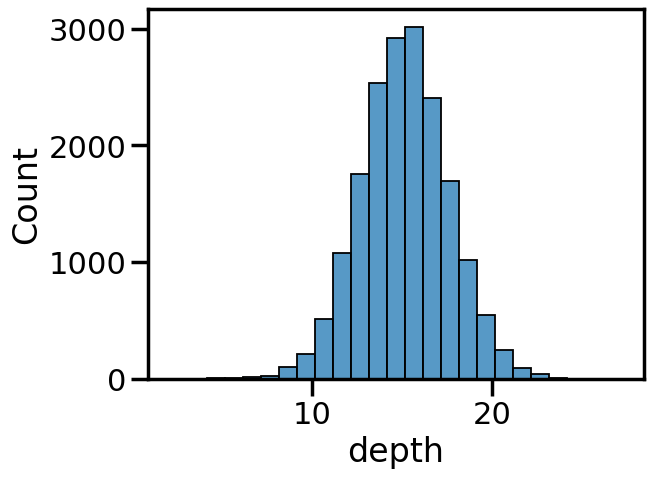

In [66]:
lower = df_comparison["depth"].quantile(0.025)
upper = df_comparison["depth"].quantile(0.975)
print(lower, upper)

ax = sns.histplot(
    df_comparison,
    x="depth",
    discrete=True
)

In [88]:
df_comparison = df_comparison.assign(
    correct = lambda x: [np.array_equal(i, j) for i, j in zip(x["genotype_constrain"], x["genotype_sim"])]
)

In [108]:
print(f"{df_comparison.shape[0] - df_comparison['correct'].sum()} ({(df_comparison.shape[0] - df_comparison['correct'].sum()) / df_comparison.shape[0] * 100:.3f}%)")


293 (1.606%)


In [109]:
print(df_comparison.shape)
df_comparison_filt = df_comparison.query(f"depth >= {lower} and depth <= {upper}")
print(df_comparison_filt.shape)

print(f"{df_comparison_filt.shape[0] - df_comparison_filt['correct'].sum()} ({(df_comparison_filt.shape[0] - df_comparison_filt['correct'].sum()) / df_comparison_filt.shape[0] * 100:.3f}%)")



(18241, 9)
(17477, 9)
247 (1.413%)


In [119]:
df_comparison_filt[~df_comparison_filt["correct"]].head(10)

,str_id,period,ref,genotype_constrain,frequencies_constrain,depth,genotype_sim,n_distinct_alleles,correct
40,chr21_14146773,1,26,"[20, 21, 21]","{20: 14, 21: 20, 26: 5}",13.000000,"[20, 21, 26]",3,False
76,chr21_14235352,2,8,"[16, 16, 16]",{8: 55},18.333333,"[16, 16, 17]",2,False
79,chr21_14243744,4,2,"[8, 8, 8]",{2: 58},19.333333,"[6, 8, 8]",2,False
89,chr21_14268035,2,12,"[24, 24, 24]",{12: 40},13.333333,"[21, 24, 24]",2,False
108,chr21_14303570,5,8,"[40, 40, 40]",{8: 46},15.333333,"[40, 40, 42]",2,False
172,chr21_14433765,4,4,"[16, 16, 16]",{4: 42},14.000000,"[16, 17, 17]",2,False
176,chr21_14438576,1,18,"[22, 22, 22]","{18: 6, 22: 31}",12.333333,"[18, 22, 22]",2,False
346,chr21_14760579,4,3,"[12, 12, 12]",{3: 47},15.666667,"[11, 11, 12]",2,False
402,chr21_14885045,1,38,"[14, 38, 38]","{14: 17, 38: 20}",12.333333,"[14, 14, 38]",2,False
414,chr21_14903033,3,4,"[12, 12, 12]",{4: 44},14.666667,"[4, 4, 12]",2,False


In [103]:
print(df_comparison.shape)
print(df_comparison["n_distinct_alleles"].value_counts())
df_comparison["n_distinct_alleles"].value_counts(normalize=True)

(18241, 9)
n_distinct_alleles
1    13465
2     3923
3      853
Name: count, dtype: int64


n_distinct_alleles
1    0.738172
2    0.215065
3    0.046763
Name: proportion, dtype: float64

In [118]:
df_comparison_filt.query("n_distinct_alleles == 3").head(10)

,str_id,period,ref,genotype_constrain,frequencies_constrain,depth,genotype_sim,n_distinct_alleles,correct
4,chr21_13998484,1,12,"[12, 13, 14]","{12: 22, 13: 18, 14: 12}",17.333333,"[12, 13, 14]",3,True
13,chr21_14079449,1,22,"[21, 22, 23]","{21: 13, 22: 12, 23: 22}",15.666667,"[21, 22, 23]",3,True
14,chr21_14079765,1,10,"[10, 11, 12]","{10: 12, 11: 23, 12: 20}",18.333333,"[10, 11, 12]",3,True
22,chr21_14094712,1,22,"[22, 31, 36]","{22: 11, 31: 10, 36: 11}",10.666667,"[22, 31, 36]",3,True
23,chr21_14106744,2,15,"[26, 30, 32]","{13: 16, 15: 18, 16: 9}",14.333333,"[26, 30, 32]",3,True
40,chr21_14146773,1,26,"[20, 21, 21]","{20: 14, 21: 20, 26: 5}",13.000000,"[20, 21, 26]",3,False
69,chr21_14213292,4,11,"[40, 44, 52]","{10: 12, 11: 11, 13: 9}",10.666667,"[40, 44, 52]",3,True
136,chr21_14375492,1,22,"[22, 25, 26]","{22: 17, 25: 12, 26: 16}",15.000000,"[22, 25, 26]",3,True
174,chr21_14436442,1,35,"[23, 24, 35]","{23: 9, 24: 16, 35: 12}",12.333333,"[23, 24, 35]",3,True
259,chr21_14581345,1,32,"[32, 37, 40]","{32: 13, 37: 8, 40: 11}",10.666667,"[32, 37, 40]",3,True


In [122]:
print(df_comparison["correct"].sum() / df_comparison.shape[0])
(df_comparison
 .filter(["n_distinct_alleles", "correct"])
 .groupby("n_distinct_alleles", as_index=False)
 .value_counts(normalize=True))

0.9839372841401239


,n_distinct_alleles,correct,proportion
0,1,True,1.000000
1,2,True,0.945450
2,2,False,0.054550
3,3,True,0.907386
4,3,False,0.092614


In [121]:
print(df_comparison_filt["correct"].sum() / df_comparison_filt.shape[0])
(df_comparison_filt
 .filter(["n_distinct_alleles", "correct"])
 .groupby("n_distinct_alleles", as_index=False)
 .value_counts(normalize=True))

0.9858671396692796


,n_distinct_alleles,correct,proportion
0,1,True,1.000000
1,2,True,0.948766
2,2,False,0.051234
3,3,True,0.927649
4,3,False,0.072351


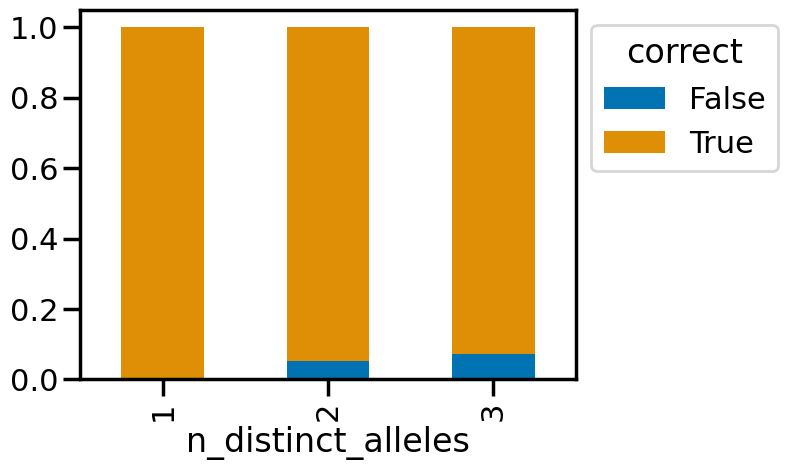

In [107]:
ax = (df_comparison_filt
 # .assign(correct = lambda x: x["genotype_constrain"] == x["genotype_sim"])
 .filter(["n_distinct_alleles", "correct"])
 .groupby("n_distinct_alleles", as_index=True)
 .value_counts(normalize=True)
 .unstack()
 .plot(
     kind="bar", 
     stacked=True, 
     color=sns.color_palette("colorblind")[:2]))

_ = ax.get_legend().set(bbox_to_anchor = (1, 1))